In [186]:
from __future__ import division
import emcee
import corner
import numpy as np
from nfw import NFW
from scipy.stats import norm
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.cosmology import FlatLambdaCDM
from time import clock

# First Model 

In [64]:
stacked_clusters = Table.read('results2fit.fits')
R = np.array(stacked_clusters['Radius'])
DSobs = np.array(stacked_clusters['Delta_Sigma_T'])
DSerr = np.array(stacked_clusters['err_Delta_Sigma_T'])
#fitmask = (R>=0.3)&(R<3.5)
fitmask = (R>=0.1)&(R<=10.0)
R = R[fitmask]
DSobs = DSobs[fitmask]
DSerr = DSerr[fitmask]

(0.3, 4)

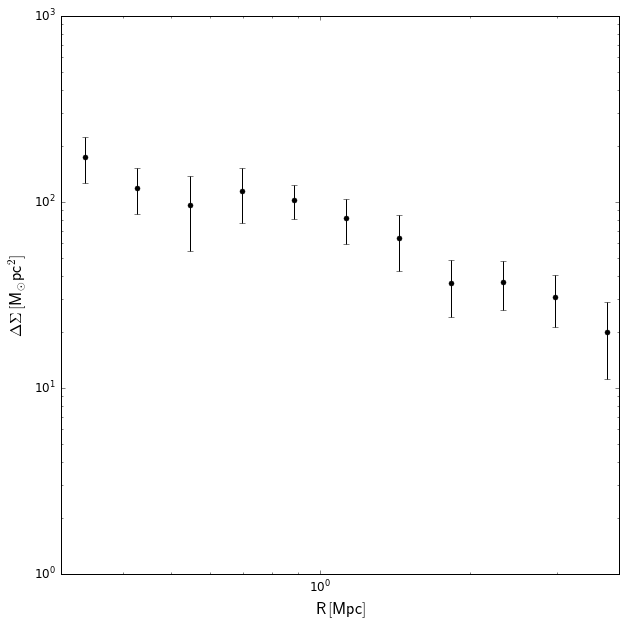

In [178]:
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(1, 1, 1, yscale='log')
plt.errorbar(R, DSobs, yerr=DSerr, mec='k', c='k', ls='none', marker='o', mfc='k', ms=5)
#plt.plot(R, DStheo_bf, 'r-')
#plt.title(title,fontsize=16)
plt.xscale('log', nonposx='clip')
plt.yscale('log', nonposy='clip')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)  
plt.xlabel(r'$\mathrm{\mathsf{R\,[Mpc]}}$', fontsize=16)
plt.ylabel(r'$ \Delta\Sigma\,\mathrm{\mathsf{[M_{\odot}pc^2]}}$', fontsize=16)
    #plt.ylim(0.1, 1000)
plt.xlim([0.3, 4])
#plt.legend(loc='best')

In [67]:
def DStheo(theta):
    z_mean = 0.215
    lm200, c = theta
    #m200=10.**lm200
    nfw = NFW(lm200, c, z_mean, cosmology=FlatLambdaCDM(H0=100, Om0=0.3)) # can change cosmology, overdensity...
    ds  = nfw.delta_sigma(R)                                             # in units of solMass/Mpc^2
    return np.array(ds.value * 1e-12)

In [68]:
def nfw_log_likelihood(theta):
    p = (( DSobs - DStheo(theta)) / DSerr)**2 + np.log(np.pi * DSerr)
    return -0.5 * np.sum(p)

In [69]:
def nfw_log_prior(theta):
    lm200, c = theta
    
    if (lm200<1e13)|(lm200>1e15):
        log_m200_prior = -np.inf
    else:
        log_m200_prior = np.log(1e15 - 1e13)
    
    if (c < 0.)|( c > 10.):
        log_c_prior = -np.inf
    else:
        log_c_prior = np.log(10.)
    
    return log_m200_prior+log_c_prior

In [70]:
def nfw_log_prior2(theta):
    lm200, c = theta
    
    if 1e12<lm200<1e15 and 1.< c <6.:
        return 0.0
    return -np.inf


In [71]:
def nfw_log_posterior(theta):
    p = nfw_log_prior2(theta)
    if not np.isfinite(p):
        return -np.inf
    return nfw_log_likelihood(theta) + p

In [72]:
m200limits = [1e12, 1e15]
climits = [0., 10.]

In [73]:
walkers, b_steps, steps = 100, 50, 200
ndim = 2

In [74]:
priors_new = ([m200limits[0], m200limits[1], climits[0], climits[1]])

In [75]:
mid = np.zeros(ndim)

In [76]:
for i in range(ndim):
    mid[i] = (priors_new[2*i] + priors_new[2*i + 1])
mid *= 0.5


In [77]:
ceros = np.zeros((ndim, walkers))
h = 1e-1

In [78]:
np.random.seed(0)
pos1=[]
for k in range(ndim):
    ceros[k,:] = mid[k] + h * np.random.normal(loc=0.0, scale=np.abs(mid[k]), size=walkers)
  

In [79]:
for i in range(walkers):
    pos1.append(np.array([ceros[0,i],ceros[1,i]]))    

In [80]:
sampler = emcee.EnsembleSampler(walkers, ndim, nfw_log_posterior)

In [81]:
pos, prob, state =sampler.run_mcmc(pos1, b_steps)

In [82]:
sampler.reset()

In [83]:
_, _, _ = sampler.run_mcmc(pos, steps, rstate0=state)

In [84]:
%matplotlib inline

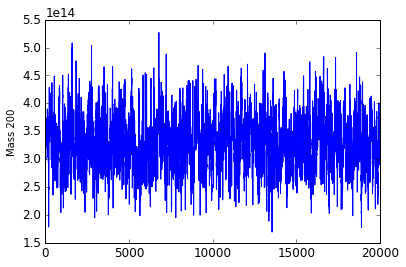

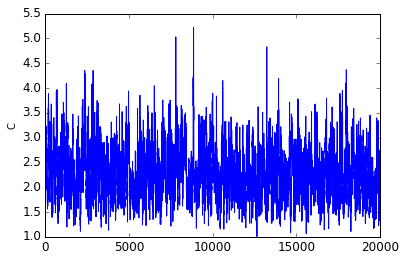

In [199]:
plt.figure()
plt.plot(sampler.flatchain[:,0])
plt.ylabel('Mass 200')
plt.figure()
plt.plot(sampler.flatchain[:,1])
plt.ylabel('C')

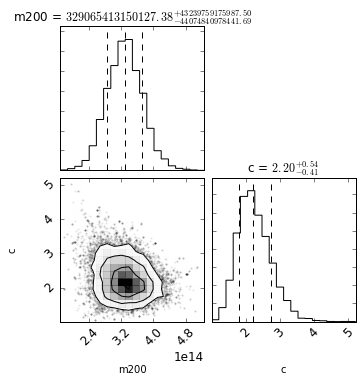

In [198]:
corner.corner(sampler.chain.reshape((-1,ndim)), labels=['m200','c'],quantiles=[0.16, 0.5, 0.84], show_titles=True);

In [87]:
def nfw_log_posterior2(theta):
    p = nfw_log_prior(theta)
    if not np.isfinite(p):
        return -np.inf
    return nfw_log_likelihood(theta) + p

In [88]:
sampler2 = emcee.EnsembleSampler(walkers, ndim, nfw_log_posterior2)

In [89]:
pos2, prob2, state2 = sampler2.run_mcmc(pos1, b_steps)

In [90]:
sampler2.reset()

In [91]:
_, _, _ = sampler2.run_mcmc(pos2, steps, rstate0=state2)

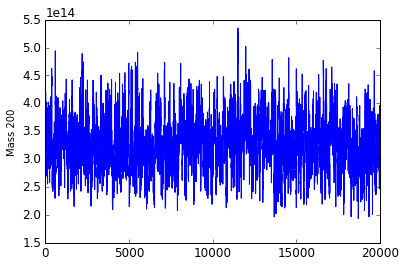

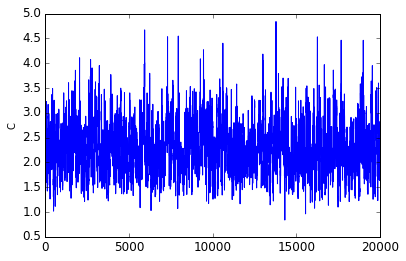

In [196]:
plt.figure()
plt.plot(sampler2.flatchain[:,0])
plt.ylabel('Mass 200')
plt.figure()
plt.plot(sampler2.flatchain[:,1])
plt.ylabel('C')

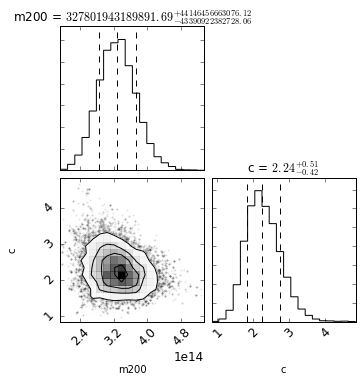

In [197]:
corner.corner(sampler2.chain.reshape((-1,ndim)), labels=['m200','c'],quantiles=[0.16, 0.5, 0.84], show_titles=True);

In [94]:
m_corr = np.zeros((walkers,steps))                
c_corr = np.zeros((walkers,steps))
m_corr2 = np.zeros((walkers,steps))
c_corr2 = np.zeros((walkers,steps))

In [95]:
for k in range(walkers):
    m_corr[k]=emcee.autocorr.function(sampler.chain[k,:,0],axis=0)
    c_corr[k]=emcee.autocorr.function(sampler.chain[k,:,1],axis=0)
    m_corr2[k]=emcee.autocorr.function(sampler2.chain[k,:,0],axis=0)
    c_corr2[k]=emcee.autocorr.function(sampler2.chain[k,:,1],axis=0)

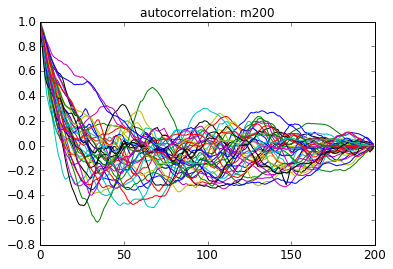

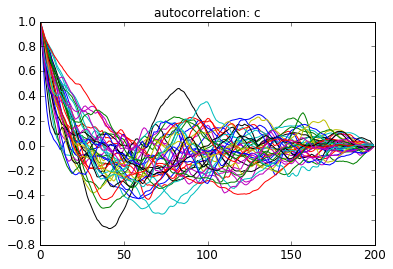

In [96]:
plt.figure()
plt.title('autocorrelation: m200')
for i in range(40):
    plt.plot(m_corr[i][:])
plt.figure()
plt.title('autocorrelation: c')
for i in range(40):
    plt.plot(c_corr[i][:])
    

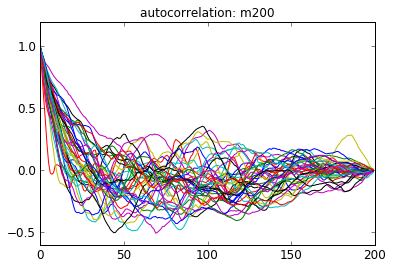

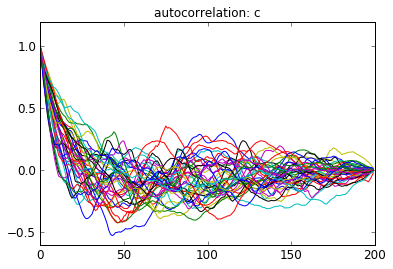

In [97]:
plt.figure()
plt.title('autocorrelation: m200')
for i in range(40):
    plt.plot(m_corr2[i][:])
plt.figure()
plt.title('autocorrelation: c')
for i in range(40):
    plt.plot(c_corr2[i][:])

(0.3, 4)

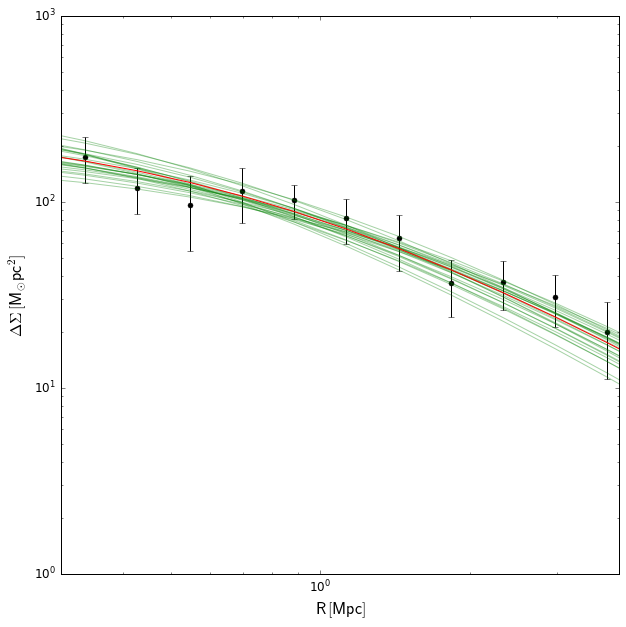

In [179]:
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(1, 1, 1, yscale='log')
plt.errorbar(R, DSobs, yerr=DSerr, mec='k', c='k', ls='none', marker='o', mfc='k', ms=5)
#plt.plot(R, DStheo_bf, 'r-')
#plt.title(title,fontsize=16)
plt.xscale('log', nonposx='clip')
plt.yscale('log', nonposy='clip')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)  
plt.xlabel(r'$\mathrm{\mathsf{R\,[Mpc]}}$', fontsize=16)
plt.ylabel(r'$ \Delta\Sigma\,\mathrm{\mathsf{[M_{\odot}pc^2]}}$', fontsize=16)

for m, c in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=25)]:
    plt.plot(R, DStheo((m,c)),'g', alpha =0.35)
mean_m = np.mean(sampler.flatchain[:,0])
mean_c = np.mean(sampler.flatchain[:,1])
plt.plot(R, DStheo((mean_m,mean_c)),'r')
plt.xlim([0.3, 4])

# Model extension

In [99]:
!pip2.7 install cluster-lensing

You are using pip version 7.0.3, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [100]:
import clusterlensing
from clusterlensing import ClusterEnsemble

In [101]:
z_mean = 0.215

In [102]:
mean_m2 = np.array([mean_m])
red = np.array([z_mean])

In [103]:
cluster = ClusterEnsemble(red, cosmology=FlatLambdaCDM(H0=100, Om0=0.3)) 
cluster.m200 = mean_m2

# Checking the input values z, m200 and c200

rbins = R                                    # Same radial bins 

misc_off = 0.1                               # miscentering offsets in Mpc

offsets = np.ones(cluster.z.shape[0])*misc_off

cluster.calc_nfw(rbins, offsets=offsets)            # NFW with offset

dsigma_offset = cluster.deltasigma_nfw.mean(axis =0)


DSmisc = dsigma_offset.value
print DSmisc

[  69.02877241   98.55855873  135.71960931  168.13419669  189.94999989
  190.61712898  174.12157988  148.97098181  121.49691949   95.72068406
   73.29417627   54.84128985   40.22752675   29.00783011   20.60984646
   14.45530736   10.02497222    6.88415209    4.68652113    3.16616575]


In [104]:
def new_DStheo(theta):
    m200, c, p_cen = theta    
    nfw = NFW(m200, c, z_mean, cosmology=FlatLambdaCDM(H0=100, Om0=0.3)) # can change cosmology, overdensity...  
    ds  = nfw.delta_sigma(R)                                             # in units of solMass/Mpc^2
    return p_cen*(np.array(ds.value/1.e12))+(1-p_cen)*DSmisc  

In [105]:
def new_log_likelihood(theta):
    p = ((DSobs - new_DStheo(theta))/(DSerr))**2 + np.log(np.pi * DSerr)
    return -0.5*np.sum(p)


In [106]:
def new_log_priors(theta):
    m200, c, p_cen = theta
     
    if (m200<1e13)|(m200>1e15):
        log_m200_prior = -np.inf
    else:
        log_m200_prior = 0.0 #-np.log(m200max-m200min)
        
    if (c<0.)|(c>10.0):
        log_c_prior = -np.inf
    else:
        log_c_prior = 0.0 #-np.log(cmax-cmin)

    if (p_cen<0.0)|(p_cen>1.0):
        log_p_cen_prior = -np.inf
    else:
        log_p_cen_prior = 0.0
        
        
    return log_m200_prior+log_c_prior+log_p_cen_prior

In [107]:
def new_log_posterior(theta):
    pt = new_log_priors(theta)
    if not np.isfinite(pt):
        return -np.inf
    return new_log_likelihood(theta) + pt

In [108]:
ndim1 = 3
n_walkers = 200

In [109]:
prior_list=([1e13, 1e15, 0., 10., 0., 1.])

In [110]:
mid2=np.zeros(ndim1)

In [111]:
for i in range(ndim1):
    mid2[i] = (prior_list[2*i] + prior_list[2*i + 1])
mid2 *= 0.5    

In [112]:
z1=np.zeros((ndim1,n_walkers))


In [113]:
initi=[]
for k in range(ndim1):
    z1[k,:] = mid2[k] + h * np.random.normal(loc=0.0, scale=np.abs(mid2[k]), size=n_walkers)

In [114]:
for i in range(n_walkers):
    initi.append(np.array([z1[0,i],z1[1,i],z1[2,i]]))  

In [115]:
sampler3 = emcee.EnsembleSampler(n_walkers, ndim1, new_log_posterior)

In [116]:
nb_steps, n_steps = 100, 350

In [117]:
pos3, prob3, state3 = sampler3.run_mcmc(initi, b_steps)

In [118]:
sampler3.reset()

In [119]:
_, _, _ = sampler3.run_mcmc(pos3, steps, rstate0=state3)

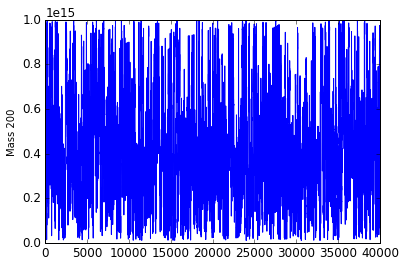

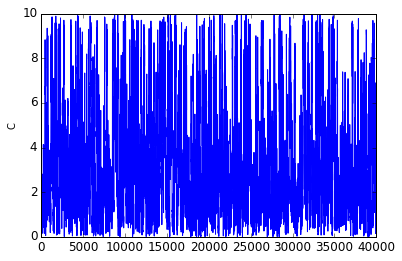

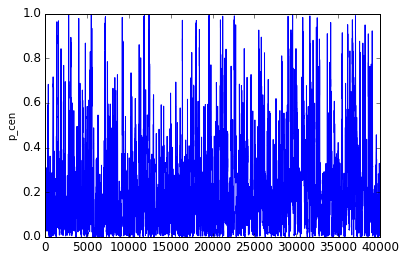

In [195]:
plt.figure()
plt.plot(sampler3.flatchain[:,0])
plt.ylabel('Mass 200')
plt.figure()
plt.plot(sampler3.flatchain[:,1])
plt.ylabel('C')
plt.figure()
plt.plot(sampler3.flatchain[:,2])
plt.ylabel('p_cen')

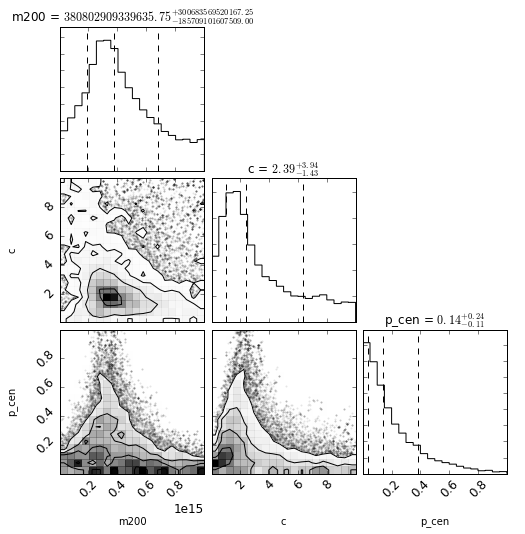

In [191]:
corner.corner(sampler3.flatchain, labels=['m200','c','p_cen'],quantiles=[0.16, 0.5, 0.84], show_titles=True);

In [122]:
m_corr3 = np.zeros((n_walkers,steps))
c_corr3 = np.zeros((n_walkers,steps))
p_corr = np.zeros((n_walkers,steps))

In [123]:
for k in range(n_walkers):
    m_corr3[k]=emcee.autocorr.function(sampler3.chain[k,:,0],axis=0)
    c_corr3[k]=emcee.autocorr.function(sampler3.chain[k,:,1],axis=0)
    p_corr[k]=emcee.autocorr.function(sampler3.chain[k,:,2],axis=0)

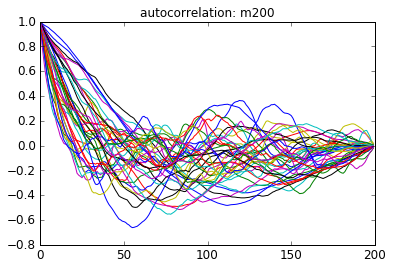

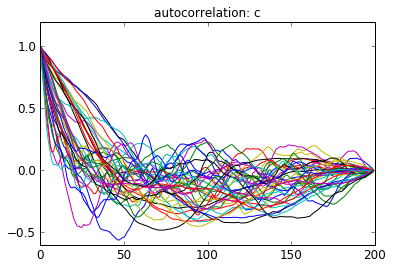

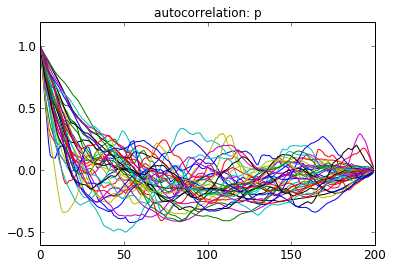

In [124]:
plt.figure()
plt.title('autocorrelation: m200')
for i in range(40):
    plt.plot(m_corr3[i][:])
plt.figure()
plt.title('autocorrelation: c')
for i in range(40):
    plt.plot(c_corr3[i][:])
plt.figure()
plt.title('autocorrelation: p')
for i in range(40):
    plt.plot(p_corr[i][:])

In [183]:
print len(sampler3.flatchain[:,1])

40000


(0.3, 4)

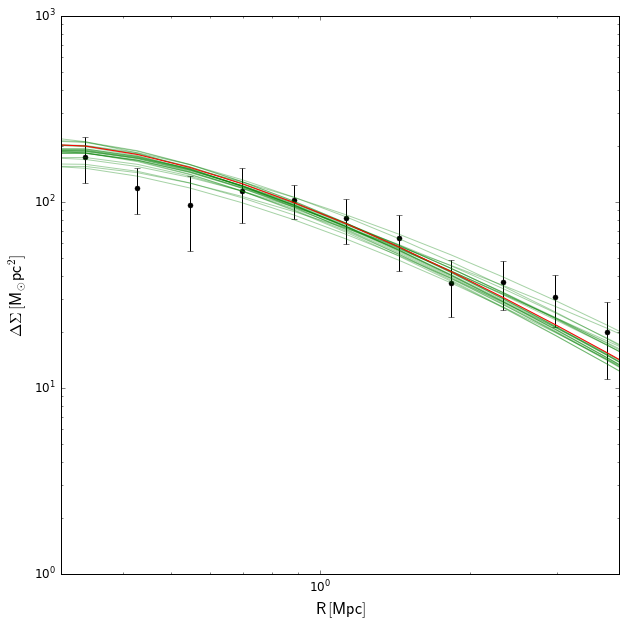

In [184]:
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(1, 1, 1, yscale='log')
plt.errorbar(R, DSobs, yerr=DSerr, mec='k', c='k', ls='none', marker='o', mfc='k', ms=5)
#plt.plot(R, DStheo_bf, 'r-')
#plt.title(title,fontsize=16)
plt.xscale('log', nonposx='clip')
plt.yscale('log', nonposy='clip')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)  
plt.xlabel(r'$\mathrm{\mathsf{R\,[Mpc]}}$', fontsize=16)
plt.ylabel(r'$ \Delta\Sigma\,\mathrm{\mathsf{[M_{\odot}pc^2]}}$', fontsize=16)

for m,c,p in sampler3.flatchain[np.random.randint(len(sampler3.flatchain), size=25)]:
    plt.plot(R, new_DStheo((m,c,p)),'g', alpha =0.35)

mean_m = np.mean(sampler3.flatchain[:,0])
mean_c = np.mean(sampler3.flatchain[:,1])
mean_p = np.mean(sampler3.flatchain[:,2])
plt.plot(R, new_DStheo((mean_m,mean_c, mean_p)),'r')
plt.xlim([0.3, 4])

# Change of Prior

In [127]:
pcen_stacked_clusters = Table.read('./Samples_p_cen_data.fits')

In [150]:
p_mu = pcen_stacked_clusters['P_CEN_mean'][3]
p_sigma = pcen_stacked_clusters['P_CEN_std'][3]
print p_mu, p_sigma

0.909486 0.140341


In [144]:
def ln_gaussian_prior(theta):
    m200, c, p_cen = theta 
       
    return -.5*((np.log(p_cen) - np.log(p_mu))*(np.log(p_cen) - np.log(p_mu))/(2*p_sigma**2))

In [145]:
def priors(theta):
    m200, c, p_cen = theta 
    
    if (m200<1e13)|(m200>1e15):
        log_m200_prior = -np.inf
    else:
        log_m200_prior = 0.0
    
    if (c < 0.)|( c > 10.):
        log_c_prior = -np.inf
    else:
        log_c_prior = 0.
        
    return log_c_prior + log_m200_prior

In [159]:
def nfw_misc_log_posterior(theta):
    m200, c, p_cen = theta
    pt2 = priors(theta) + ln_gaussian_prior(theta)
    if not np.isfinite(pt2):
        return -np.inf
    return new_log_likelihood(theta) + pt2

In [160]:
sampler4 = emcee.EnsembleSampler(n_walkers, ndim1, nfw_misc_log_posterior)

In [161]:
pos4, prob4, state4 = sampler4.run_mcmc(initi, b_steps)

In [162]:
sampler4.reset()

In [189]:
initial=clock()
_, _, _ = sampler4.run_mcmc(pos4, steps, rstate0=state4)
final=clock()
print('time:', final-initial, 'seconds')

('time:', 119.791696, 'seconds')


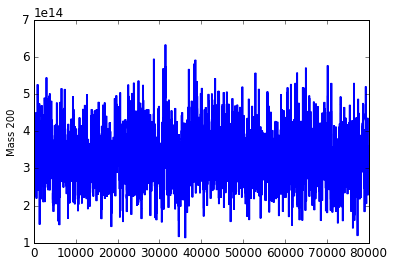

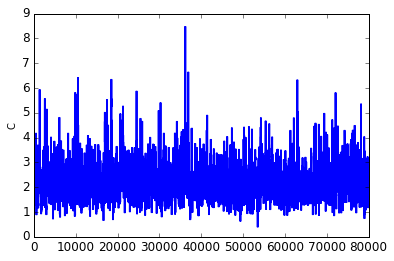

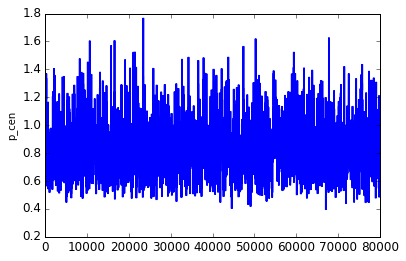

In [194]:
plt.figure()
plt.plot(sampler4.flatchain[:,0])
plt.ylabel('Mass 200')
plt.figure()
plt.plot(sampler4.flatchain[:,1])
plt.ylabel('C')
plt.figure()
plt.plot(sampler4.flatchain[:,2])
plt.ylabel('p_cen')

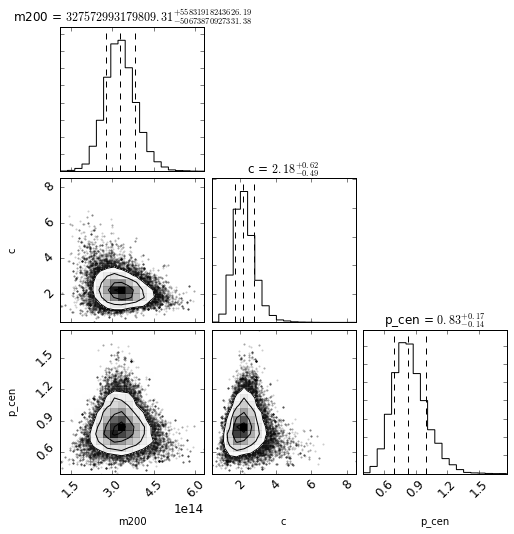

In [192]:
corner.corner(sampler4.flatchain, labels=['m200','c','p_cen'], quantiles=[0.16, 0.5, 0.84], show_titles=True);

In [167]:
m_corr4 = np.zeros((n_walkers,steps))
c_corr4 = np.zeros((n_walkers,steps))
p_corr1 = np.zeros((n_walkers,steps))

In [168]:
for k in range(n_walkers):
    m_corr4[k]=emcee.autocorr.function(sampler4.chain[k,:,0],axis=0)
    c_corr4[k]=emcee.autocorr.function(sampler4.chain[k,:,1],axis=0)
    p_corr1[k]=emcee.autocorr.function(sampler4.chain[k,:,2],axis=0)

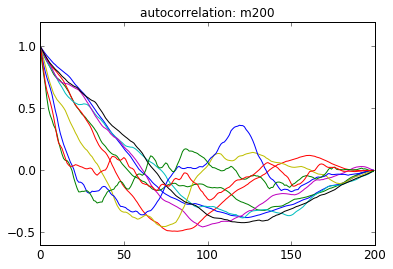

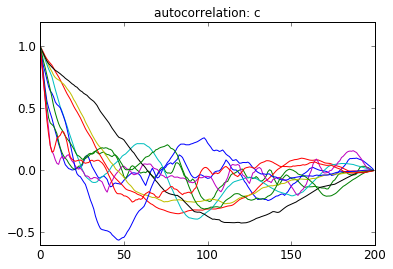

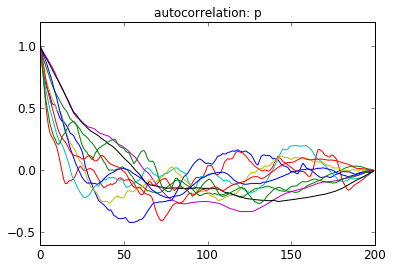

In [170]:
plt.figure()
plt.title('autocorrelation: m200')
for i in range(10):
    plt.plot(m_corr3[i][:])
plt.figure()
plt.title('autocorrelation: c')
for i in range(10):
    plt.plot(c_corr3[i][:])
plt.figure()
plt.title('autocorrelation: p')
for i in range(10):
    plt.plot(p_corr[i][:])

(0.3, 4)

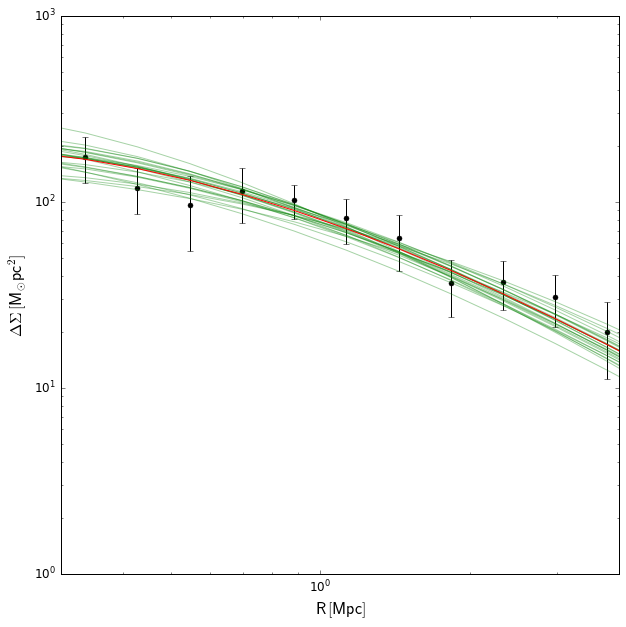

In [185]:
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(1, 1, 1, yscale='log')
plt.errorbar(R, DSobs, yerr=DSerr, mec='k', c='k', ls='none', marker='o', mfc='k', ms=5)
#plt.plot(R, DStheo_bf, 'r-')
#plt.title(title,fontsize=16)
plt.xscale('log', nonposx='clip')
plt.yscale('log', nonposy='clip')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)  
plt.xlabel(r'$\mathrm{\mathsf{R\,[Mpc]}}$', fontsize=16)
plt.ylabel(r'$ \Delta\Sigma\,\mathrm{\mathsf{[M_{\odot}pc^2]}}$', fontsize=16)

for m, c, p in sampler4.flatchain[np.random.randint(len(sampler4.flatchain), size=25)]:
    plt.plot(R, new_DStheo((m,c,p)),'g', alpha =0.35)
mean_m = np.mean(sampler4.flatchain[:,0])
mean_c = np.mean(sampler4.flatchain[:,1])
mean_p = np.mean(sampler4.flatchain[:,2])
plt.plot(R, new_DStheo((mean_m,mean_c, mean_p)),'r')
plt.xlim([0.3, 4])